In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import join as oj
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn import metrics
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
import pickle as pkl
from tqdm import tqdm
import train_reg
#df = data.get_tracks() # note: different Xs can be different shapes
#df = data.remove_invalid_tracks(df)
#df = data.preprocess(df)
#df = data.add_outcome(df)
#n = df.shape[0]

In [9]:
df = data.get_data()
n = df.shape[0]
df.keys()

Index(['X', 'X_extended', 'Y', 'X_starts', 'Y_starts', 'X_ends', 'Y_ends',
       'X_pvals', 'Y_pvals', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'lifetime_extended', 'x_pos',
       'y_pos', 'cell_num', 'pid', 'X_max', 'X_max_extended', 'X_min',
       'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std', 'X_peak_idx',
       'Y_peak_idx', 'X_peak_time_frac', 'slope_end', 'X_peak_last_15',
       'X_peak_last_5', 'rise', 'fall', 'rise_extended', 'fall_extended',
       'rise_slope', 'fall_slope', 'rise_local_3', 'fall_local_3',
       'rise_local_11', 'fall_local_11', 'max_diff', 'min_diff', 'y_score',
       'y_thresh', 'y', 'y_num_sig', 'y_single_sig', 'y_double_sig',
       'y_conservative_thresh', 'y_consec_sig', 'y_sig_min_diff',
       'y_consec_thresh', 'sig_idxs', 'hotspots', 'X_smooth_spl',
       'X_smooth_spl_dx', 'X_smooth_spl_d2x', 'X_max_spl', 'dx_max_spl',
       'd2x_max_spl', 'num_local_max_spl', 'num_local_min_spl', 'pc_0', 'pc_1',
     

### RF nearest neighbor

In [220]:
spike_time = df['X_peak_idx'].values/df['lifetime'].values

In [222]:
df['X_spike_time'] = spike_time

In [223]:
import rf_neighbors
df_train, df_test = rf_neighbors.get_rf_neighbors(df, 
                              feat_names=feat_names[:15] + ['X_spike_time'], 
                              outcome_def = 'y_consec_thresh',
                              balancing_ratio=1.2, 
                              feature_selection=None, 
                              feature_selection_num=11)

In [242]:
y_test = df_test[outcome_def].values
pos = np.where(y_test == 1)
pos_probs = df_test['preds_proba'].iloc[np.where(y_test == 1)].values
largest_fn = pos[0][np.argsort(pos_probs)[:10]]

In [244]:
print(np.sort(pos_probs)[:10])
print(df_test['nearest_neighbors'].iloc[largest_fn[0]])
print(df_test['similarity'].iloc[largest_fn[0]])
nns = df_test['nearest_neighbors'].iloc[largest_fn[0]]
print(df_train[outcome_def].values[nns])

[0.12 0.18 0.21 0.22 0.24 0.26 0.26 0.31 0.31 0.36]
[572   3 369 178 547 176  46  94 772 402]
[49. 39. 33. 30. 30. 28. 28. 28. 27. 27.]
[False False False False False False False False False False]


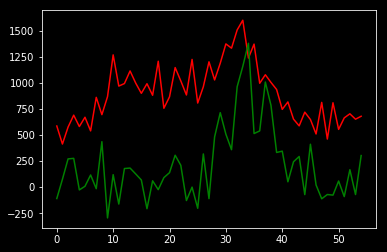

In [247]:
plt.plot(df_test.iloc[largest_fn[1]].X, color='red')
plt.plot(df_test.iloc[largest_fn[1]].Y, color='green')
plt.show()

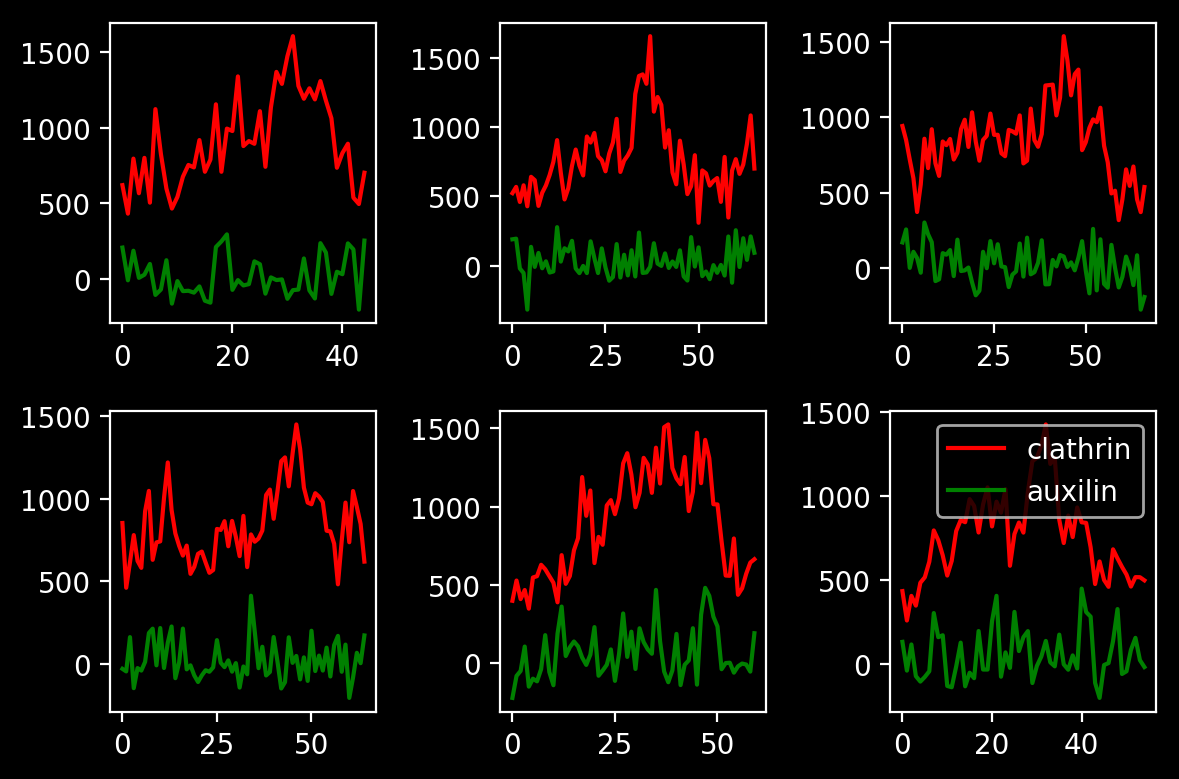

In [248]:
R, C = 2, 3
plt.figure(figsize=(6, 4), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    n1 = df_test['nearest_neighbors'].iloc[largest_fn[1]][i]
    plt.plot(df_train.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df_train.iloc[n1].Y, color='green', label='auxilin')
plt.legend()
plt.tight_layout()
plt.show()

### Histogram of distance to nearest neighbor

(array([11.,  8.,  3.,  8., 12., 12.,  5.,  8.,  2.,  2.,  8., 13., 12.,
         5.,  4.,  7.,  4.,  1., 13.,  5.,  4.,  6., 17.,  3., 10.,  5.,
         4.,  5.,  3.,  8.,  9.,  7.,  9.,  5.,  6.,  4.,  1.,  0.,  4.,
         1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  1.]),
 array([ 0.2826507 ,  0.67608696,  1.06952323,  1.4629595 ,  1.85639576,
         2.24983203,  2.64326829,  3.03670456,  3.43014083,  3.82357709,
         4.21701336,  4.61044962,  5.00388589,  5.39732215,  5.79075842,
         6.18419469,  6.57763095,  6.97106722,  7.36450348,  7.75793975,
         8.15137602,  8.54481228,  8.93824855,  9.33168481,  9.72512108,
        10.11855734, 10.51199361, 10.90542988, 11.29886614, 11.69230241,
        12.08573867, 12.47917494, 12.87261121, 13.26604747, 13.65948374,
        14.05292   , 14.44635627, 14.83979254, 15.2332288 , 15.62666507,
        16.02010133, 16.4135376 , 16.80697386, 17.20041013, 17.5938464 ,
        17.98728266, 18.38071893, 18.77415519, 19.16759146,

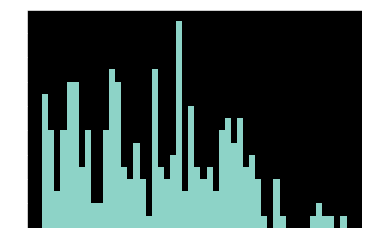

In [48]:
centers_1 = np.array(df.iloc[np.where(df['cell_num'] == 1)]['track_centers'])
centers_image = np.zeros((255, 450))
for center in centers_1:
    #print(center)
    centers_image[int(center[1]), int(center[0])] = 1
min_dist = [np.min([(centers_1[j][0] - centers_1[i][0])**2 + (centers_1[j][1] - centers_1[i][1])**2 
        for j in range(len(centers_1)) if j!=i]) for i in range(len(centers_1))]

plt.hist(np.sqrt(min_dist), bins=50)

### Location of hotspots

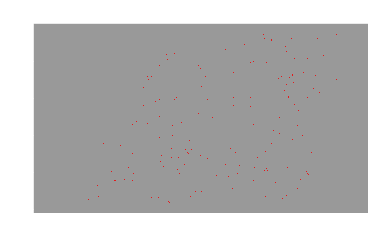

In [9]:
plt.imshow(1-centers_image, cmap="Set1")
plt.title("Locations of track centers")
plt.show()

In [13]:
min_dist_order = np.argsort(min_dist)

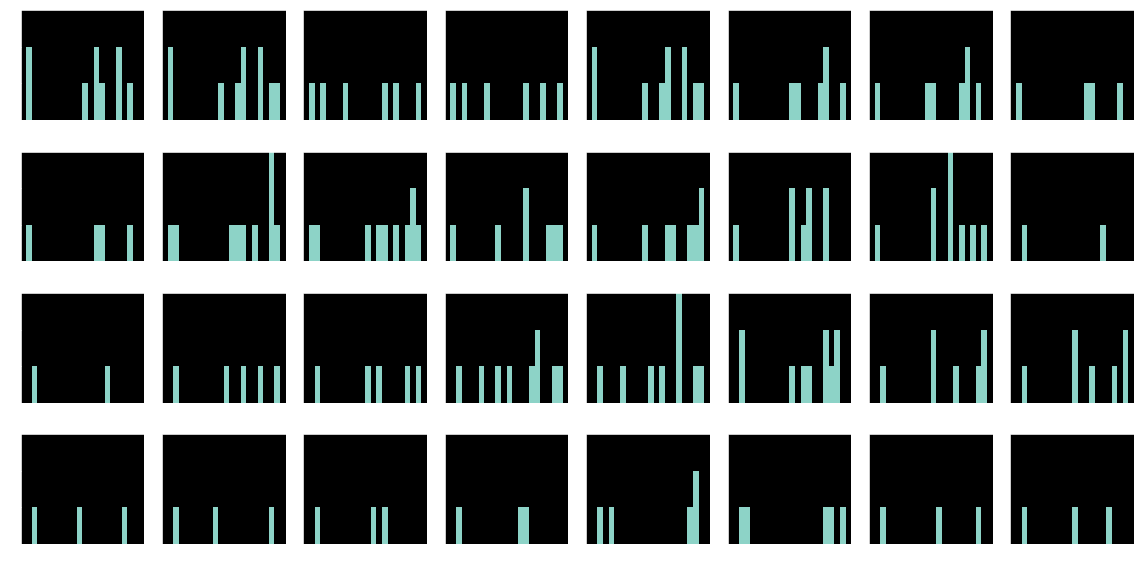

In [97]:
R, C = 4, 8
i = 0
plt.figure(figsize=(2*C, 2*R))
# plt.figure(dpi=200)
# vmin = mat.min()
# vmax = mat.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        dists = dist_mat[min_dist_order[i],:]
        plt.hist(dists, bins=20, range=(0, 20))
        #plt.xlim((-1, 20))
        plt.ylim((0, 3))
        i += 1
#         plt.ylim((vmin, vmax))
        if c > 0:
            plt.yticks([])
plt.tight_layout()
#plt.savefig('peak_aligned.pdf')
plt.show()

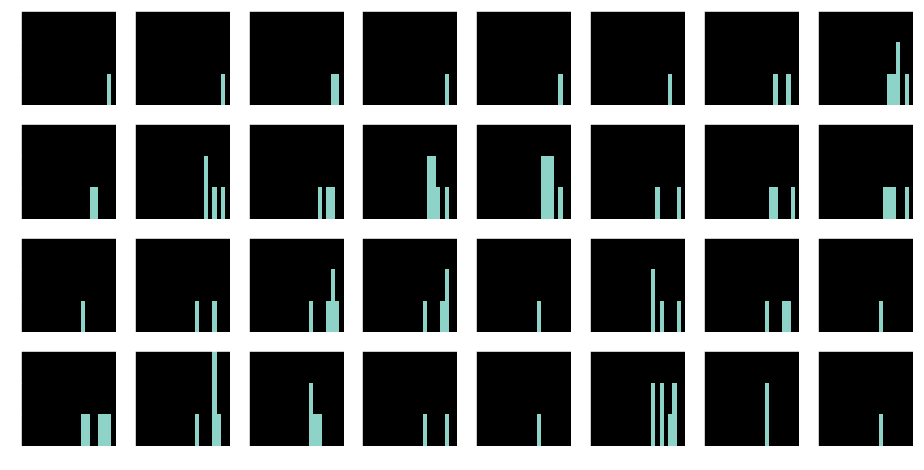

In [91]:
R, C = 4, 8
i = 0
plt.figure(figsize=(2*C, 2*R))
# plt.figure(dpi=200)
# vmin = mat.min()
# vmax = mat.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        ax = plt.subplot(R, C, i + 1)
        dists = dist_mat[min_dist_order[-(i+1)],:]
        ax.hist(dists, bins=20, range=(0, 20))
        #ax.set_xlim((-1, 20))
        ax.set_ylim((0, 3))
        i += 1
#         plt.ylim((vmin, vmax))
        if c > 0:
            plt.yticks([])
#plt.tight_layout()
#plt.savefig('peak_aligned.pdf')
#plt.show()

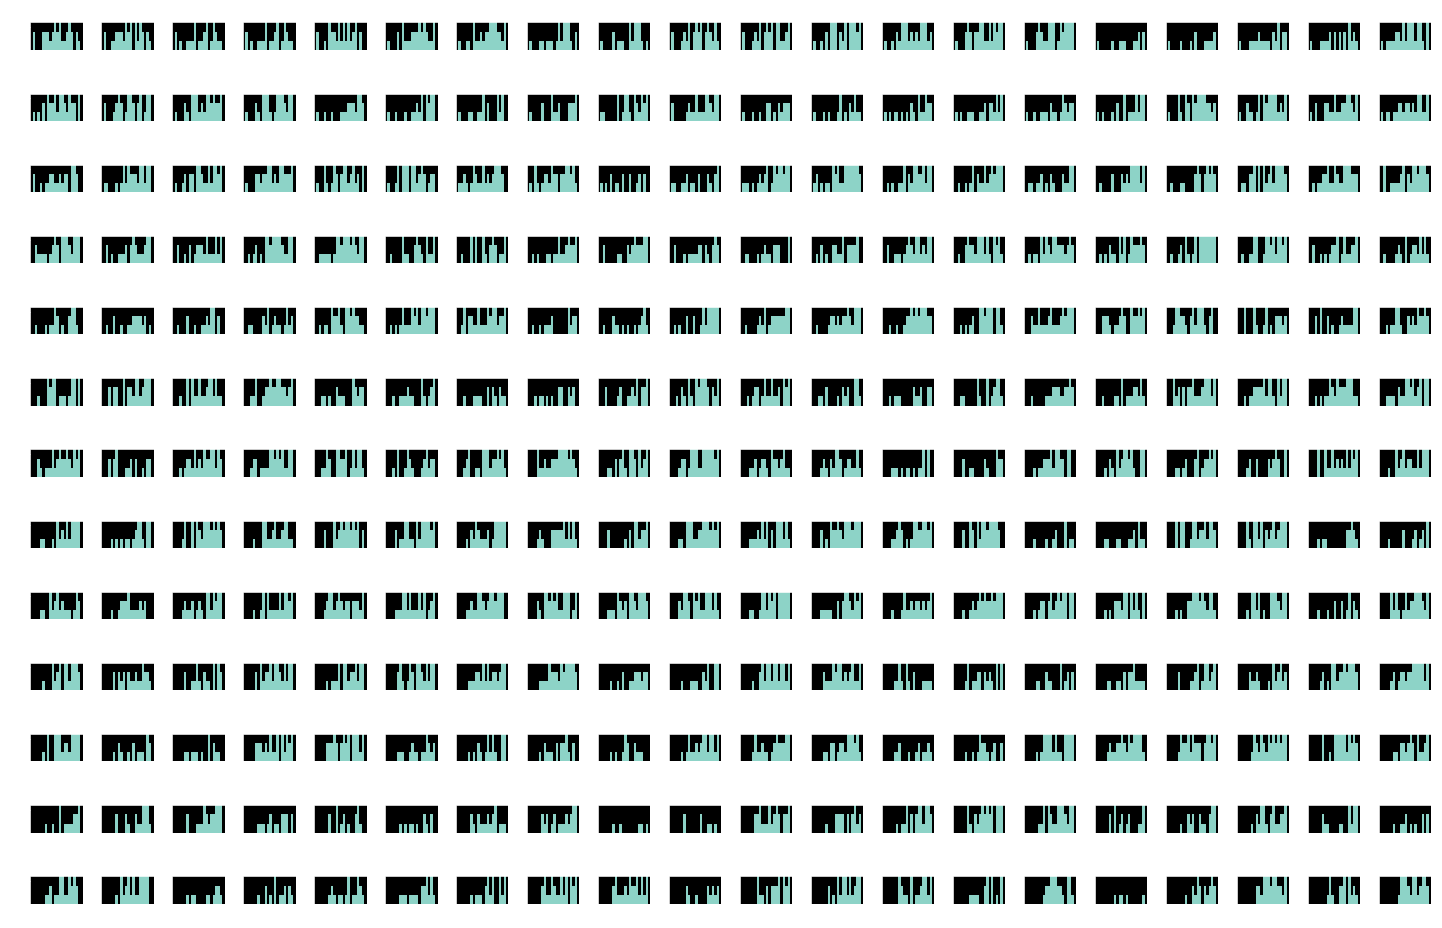

In [96]:
R, C = 13, 20
i = 0
plt.figure(figsize=(C, R))
# plt.figure(dpi=200)
# vmin = mat.min()
# vmax = mat.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        dists = dist_mat[min_dist_order[i],:]
        plt.hist(dists, bins=20, range=(0, 50))
        #plt.xlim((-1, 20))
        plt.ylim((0, 3))
        s = str(i)
        plt.title(s)
        i += 1
#         plt.ylim((vmin, vmax))
        #if r < R-1:
        #    plt.xticks([])
        if c > 0:
            plt.yticks([])
plt.tight_layout()
#plt.savefig('peak_aligned.pdf')
plt.show()

### Max strength prediction

In [38]:
df = data.get_data(use_processed=False)
df = train_reg.add_robust_features(df)
df = train_reg.log_transforms(df)

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	removing hotspots....
	adding features...


In [54]:
outcome_def = 'Y_max_lg'
out_dir = f'results/regression/feb10_2/{outcome_def}'
df[outcome_def] = np.log(df['Y_max'])
os.makedirs(out_dir, exist_ok=True)
feat_names_log = ['X_95_quantile_log', 'X_mad_log', 
              'total_displacement','mean_square_displacement', 'lifetime', 
              'rise_log', 'fall_log', 'rise_local_3_log', 'rise_local_11_log', 
                  'fall_local_3_log', 'fall_local_3_log']
feat_names = data.get_feature_names(df)

# don't use dict_feats
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max',
                           'X_max_around_Y_peak', 'X_max_after_Y_peak']
              and not x.startswith('pc_')
#               and not 'slope' in x
             ]
#print(feat_names)
for model_type in tqdm(['linear', 'gb', 'rf', 'svm', 'ridge']):
    out_name = f'{model_type}'
                    #print(out_name)
    train_reg.train_reg(df, feat_names=feat_names, model_type=model_type, 
                 outcome_def=outcome_def,
                 out_name=f'{out_dir}/{out_name}.pkl')    



  0%|          | 0/5 [00:00<?, ?it/s]

[0.16467608545058054, 0.25603293020646434, 0.16510388248022545, -0.0758826010960767, 0.11937250029752033]



 40%|████      | 2/5 [00:02<00:03,  1.25s/it]

[0.19718263406873116, 0.28756429185787113, 0.13726905637742426, -0.051239182962508734, 0.19154043836065116]



 60%|██████    | 3/5 [00:18<00:11,  5.62s/it]

[0.19096756366610368, 0.2809583836476661, 0.17133305500325713, -0.02409943533134129, 0.23349438276666212]



100%|██████████| 5/5 [00:19<00:00,  3.92s/it]

[0.15120535203965402, 0.21950489654861105, 0.11946648036769714, -0.16655711152899477, 0.19155240605616808]
[0.1648737288443218, 0.2562673909411063, 0.16335862175268712, -0.07571883880915076, 0.12203748866030661]


In [55]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r['r2']
#r.style.background_gradient(cmap='binary', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

model_type
rf        0.160
gb        0.142
ridge     0.112
linear    0.111
svm       0.088
Name: r2, dtype: float64

Text(0, 0.5, 'r2')

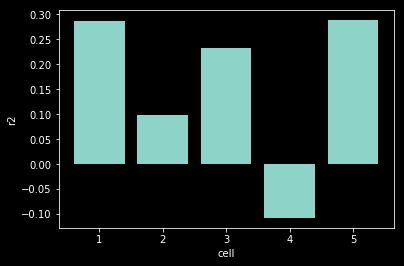

In [165]:
plt.bar(range(1, 6), r['cv_accuracy_by_cell'][0])
plt.xlabel('cell')
plt.ylabel('r2')

In [118]:
x_argmax = np.array([np.argmax(df.iloc[i].X) for i in range(len(df))])
ymax_after_cla_peak = np.array([np.max(df.iloc[i].Y[x_argmax[i]:]) for i in range(len(df))])
df['y_after_cla_peak'] = ymax_after_cla_peak
df['y_after_cla_peak_log'] = np.log(ymax_after_cla_peak - min(ymax_after_cla_peak) + 1)

-223.07639804291784


[260 258 183 325 267]


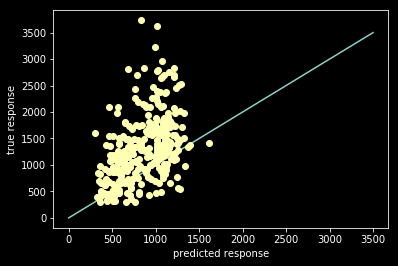

In [195]:
fname = 'gb.pkl'
d = pkl.load(open(oj(out_dir, fname), 'rb'))
print(d['num_pts_by_fold_cv'])
plt.plot(range(3500), range(3500))
plt.plot(np.exp(d['y_preds'][4]), np.exp(df.iloc[np.where(df['cell_num'] == 4)]['Y_max_log']), 'o')
plt.xlabel('predicted response')
plt.ylabel('true response')
plt.show()

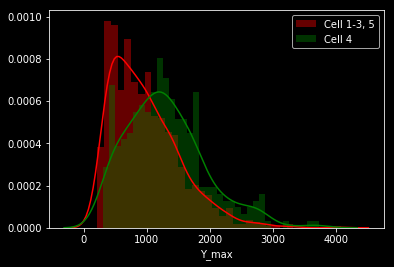

In [196]:
df_val = df.iloc[np.where(df['cell_num'] == 4)]
df_train = df[df.cell_num.isin([1, 2, 3, 5])]
sns.distplot(df_train['Y_max'], hist=True, kde=True, 
             bins=int(180/5), color='red', label='Cell 1-3, 5')
sns.distplot(df_val['Y_max'], hist=True, kde=True, 
             bins=int(180/5), color='green', label='Cell 4')
plt.legend()

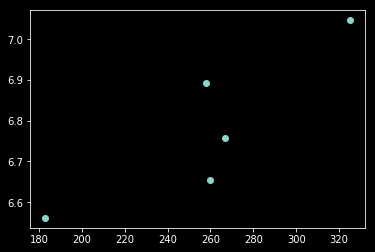

In [197]:
n_tracks = d['num_pts_by_fold_cv']
y_max_median = [np.mean(df.iloc[np.where(df['cell_num'] == i)]['Y_max_log']) for i in range(1, 6)]
plt.plot(n_tracks, y_max_median, 'o')

# basic eda

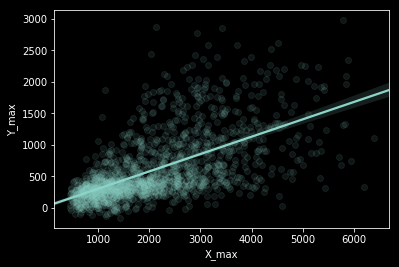

In [18]:
sns.regplot('X_max', 'Y_max', df, scatter_kws={'alpha': 0.1})

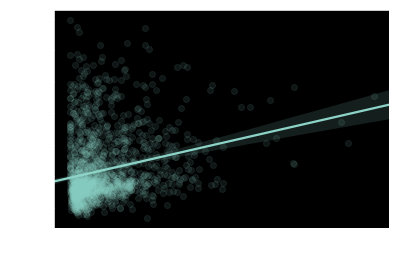

In [3]:
sns.regplot('totalDisplacement', 'Y_max', df, scatter_kws={'alpha': 0.1})

In [34]:
m = RidgeCV(store_cv_values=True)
m.fit(df['X_max'].values.reshape(-1, 1), df['Y_max'].values.reshape(-1, 1), )

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=True)

In [37]:
m.cv_values_[0]

array([[9359.74290596, 9359.74286412, 9359.74244571]])

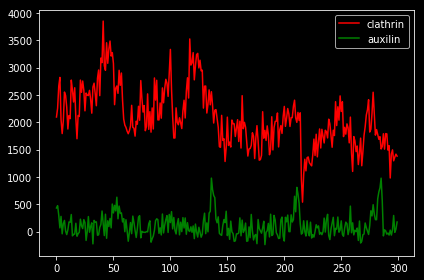

In [91]:
# 0 is the first channel (clathrin)
R, C = 1, 1
# R, C = 5, 5
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
plt.legend()

plt.tight_layout()
plt.show()

# fit maxconv

In [2]:
# pad lists with zeros
X_mat = data.extract_X_mat(df)
Y_max = df['Y_max'].values.astype(np.float32)
Y_max -= np.min(Y_max)
Y_max /= np.std(Y_max) # zero min, stddev 1
# X_feat, Y_max = data.extract_single_pixel_features(X, Y)
# Y_max -= np.min(Y_max) # make all vals positive
# print('shapes', X_feat.shape, Y_max.shape)

# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, Y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

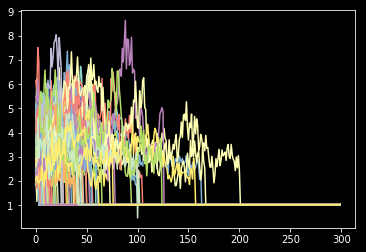

In [15]:
for i in range(100):
    plt.plot(X_train[i])

In [16]:
conv_size = 10
num_channels = 1
dirname = oj('out', f'conv_size={conv_size}_num_channels={num_channels}')
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConv(num_units=num_channels, kernel_size=conv_size, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

In [ ]:
# train
net.fit(X_train, Y_train.reshape(-1, 1))
# pkl.dump(net, open( "net_big.pkl", "wb" ))

Re-initializing optimizer.
(10,)
offset 0.15514989


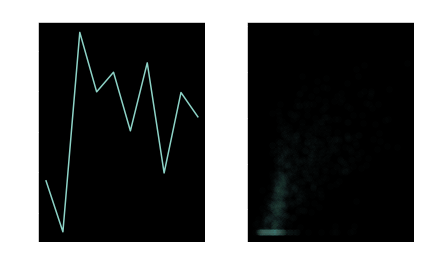

In [31]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 2

ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
print(ws.shape)
print('offset', net.module_.state_dict()['offset'].cpu().numpy().squeeze())

plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
preds = net.predict(X_train)
plt.plot(Y_train, preds, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_train - preds)):0.2f} r2 {metrics.r2_score(Y_train, preds):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()